In [1]:
import numpy as np 
import matplotlib.pyplot as plt

from sklearn import linear_model
import statsmodels.formula.api as sm

from tqdm import tqdm

import scipy.io as sio
# for my supacool dark theme:
plt.style.use('dark_background')

## Real data

We tried to use the MAF (Minor Allele Frequency) given by the github https://github.com/ShashaankV/GD but the size was too big for computing on a single computer. Nonetheless, we use similar order of value (between $0.1$ and $0.5$ for the parameters of the binomial probabilities).

In [2]:
path2data= ''
#maf = sio.loadmat('GD/chr22_maf.mat')['maf']
#print(maf.shape)
#maf

## Simulated data

In [54]:
def simul_data(n, p=500, maf=None, miss = 0., miss_value='average'):
    '''
    return a random sample of size n of coefficients following a binomial 
    of parameter 2 and probability equal to maf 
    Input: n, p, eventually a MAF (Minor Allel Frequency) vector 
    output A, the genotype matrix
    '''
    A = []
    # if no MAF is provided, we simulate a MAF array (an array of probabilities)
    if maf is None:
        maf = np.random.uniform(low=0.1, high=0.5, size = (1, p))
    else:
        for idx, i in enumerate(maf[0]):
            if i < 0.01:
                maf[0][idx] = 0.01
    for _ in range(n):
        A.append(np.random.binomial(2, maf)[0])
    A = np.array(A)
    
    # Scaling the Matrix in order to verify isotropy (see next block)
    A = (A-2*maf)/(2*maf*(1-maf))/np.sqrt(n)
    
    return A

# Example of use :  
# B = simul_data(5000, p=10)
# B.shape

In fact, we simulate a matrix $(a_{i,j})$ of coefficient in ${0, 1, 2}$ where each coefficient of the same column follow the same probability distribution. In order to verify isotropy : $$\mathbb{E}[A^T A] = I$$
We only need to have $$\mathbb{E}\left[ \sum_{i=1}^{n} a_{i,j}\right] =1 $$. To verify this case, we center the elements and scale them by the variance and $\sqrt{n}$.

In [14]:
def genPhenotype(A, s, h2 = 1., xtype = 'uniform'):
    '''Simulate Phenotype y given a genotype matrix A
    Input:  A, genotype matrix (either real or simulated data)
            s, sparsity of the x vector (number of non zeros coeffs)
            h2, heritability (ratio of the phenotype explained by the genotype)
            xtype, in ['uniform', 'hyperExp'(not coded yet)], type of coefficients simulated 
    Output: x, 
    '''

    assert xtype in ['uniform', 'hyperExp'], 'Error, xtype should be "uniform" or "hyperExps"'
    
    n = A.shape[0]
    p = A.shape[1]
    x = np.random.uniform(-1,1,p)
    
    if xtype == 'hyperExp':
        x = np.exp(-(np.arange(p) + 1) / (.05*s)) + np.exp(-(np.arange(p)+1)/p)
    # set s coefficients to zeros
    x_mask = np.random.choice(np.arange(p), p-s, replace= False)
    x[x_mask] = 0
    # heritability
    if h2<1.:
        x = np.sqrt(h2) * x / np.std(A.dot(x))
        e = np.sqrt(1.-h2) * np.random.normal(size = n)
        y = A.dot(x) + e
        return x, y, e
    else:
        x = x/np.std(A.dot(x))
        return x, A.dot(x), 0
    
# Example of use
# genPhenotype(At, st)

In [15]:
A = simul_data(100, 10)
x, y, e = genPhenotype(A, 10, h2=0.5)

## Recovery algorithm: Linear regression with Lasso

We solve the following minimisation problem using scikit-learn : 
$$min_x [\Vert y -Ax \Vert_{L_2}^2+\lambda \Vert x \Vert_{L_1}]$$

In [16]:
def lasso(A, y, lambd = 0.1, normalize = True):
    """return the coefficient of the lasso regression of A over y, lambd is the regulizer parameter
    """
    reg = linear_model.Lasso(lambd/(2*A.shape[0]), normalize = normalize)
    reg.fit(A, y)
    return reg.coef_

In [17]:
def iterativeLasso(A, y, nb_lambd=100, normalize=True):
    """implement the iterative lasso with the same regularization path as in the paper"""
    n = A.shape[0]
    lambd_max = np.linalg.norm(y.dot(A), ord = np.inf)/n
    e = np.random.normal(size=(1000, n))
    Ae_inf = [np.linalg.norm(v, ord = np.inf) for v in e.dot(A)]
    var_e_corrected = np.sqrt(1 + 1/n)
    lambd_min = np.median(Ae_inf) * var_e_corrected/n
    alphas = np.linspace(lambd_min, lambd_max, nb_lambd)/(n)
    reg = linear_model.LassoCV(alphas=alphas, normalize=normalize)
    reg.fit(A, y)
    return reg.coef_, reg.alpha_

## Recovery measures:

We implemented the different recovery measures developped in the paper as well as the normalisation error:

* **NE**, $\frac{||x-\hat x||}{||x||}$

* **PPV**, Positive Predicted Value: the ratio between the number of True Positive and the number of selected Positive coefficients (i.e. the number of non-zero coefficients: $\frac{\#\{x_i : x_i\neq 0;\hat x_i \neq 0\}}{\#\{\hat x_i:\hat x_i \neq 0\}}$

* **FPR**, False Positive Rate: the ratio between the number of False Positive and the total number of Negative coefficients (i.e. the number of zero coefficients): $\frac{\#\{x_i : x_i = 0;\hat x_i \neq 0\}}{\#\{x_i:x_i = 0\}}$ 

* **$med_{P-val}$**, the median of the P-values obtained when regressing the phenotypes on each selected SNP. For each of this regression, we compute the p-value associated to the t-test asserting if the coefficient of the regression is zero. We then take the median of these p-values. Note that, contrary to the other measures of recovery, this one could be computed in real experiments where we don't have access to the true coefficients x.

In [18]:
# Normalisation Error (NE)
def NE(x, x_hat):
    return np.linalg.norm(x-x_hat)/np.linalg.norm(x)


# positive predictive value
def PPV(x, x_hat):
    nb_tp = np.sum([1 for u,v in zip(x, x_hat) if (u != 0) and (v != 0)])
    nb_pos = np.sum([1 for e in x_hat if e!=0])
    assert nb_pos !=0, 'mError, x_hat is null!'
    return nb_tp/nb_pos


# false posive rate
def FPR(x, x_hat):
    nb_fp = np.sum([1 for u,v in zip(x, x_hat) if (u==0) and (v!=0)])
    nb_neg = np.sum([1 for e in x if e==0])
    if nb_neg ==0:
        print('FPR computation Warning, x is not sparse!')
        return -1
    return nb_fp/nb_neg


# Median P-values of the single coefficient regressions
def med_P(x_hat, y, A, verbose = False):
    p_vals = []
    for i in np.arange(len(y)):
        if x_hat[i] != 0:
            snp = A[:,i]
            reg = sm.OLS(y, snp).fit()
            p_vals.append(reg.t_test([1]).pvalue) 
    measure = np.median(np.array(p_vals))
    if verbose:
        print('{} selected non zero coefficients (over {} total number of SNPs)'.format(len(p_vals), len(x_hat)))
    return measure

## Phase-transition 

In [19]:
# for the simulated assays
def phase_transition_mat(A, lambd = 0.1, h2 = 1., xtype = 'uniform', size = 20, recovery = False):
    """
    return return a size by size matrix with the NE score for the lasso reconstruction procedure 
    A, measurement matrix (genotype)
    h2, heritability (ratio of the phenotype explained by the genotype)
    xtype, in ['uniform', 'hyperExp'(not coded yet)], type of coefficients simulated 
    size, the size of the phase transition matrix
    lambd, the regularization parameter for lasso
    """
    # number of samples
    n = A.shape[0]
    # number of SNPs
    p = A.shape[1]
    # store paramater for the plot
    params = [n, p, h2, xtype, lambd]
    # In order to test all values for delta, we need to have enough data
    assert n==p, "ERROR, n must be equal to p (to explore the complete delta-rho plane)"
    
    PTM = np.zeros((size, size))
    ix = np.arange(n)
    
    if recovery:
        PPV_mat = np.zeros((size, size))
        FPR_mat = np.zeros((size, size))
        medP_mat = np.zeros((size, size))
    for i in tqdm(range(size)):

        for j in range(size):
            rho = (i+1)/size
            delta = (j+1)/size
            
            n_tmp = int(p*delta)
            s = int(rho*n_tmp)

            ix_tmp = np.random.choice(ix, n_tmp, replace=False)
            A_tmp = A[ix_tmp][:]
            x, y, e = genPhenotype(A=A_tmp, s=s, h2=h2)
            
            # Choose if you want to prefer either a cross validation to select lambdas
            # or a standart lasso with a given lambda (faster)
            x_pred = lasso(A_tmp, y, lambd = lambd)
            # x_pred, la = iterativeLasso(A_tmp, y, nb_lambd=100, normalize=True, verbose=False)
            norm = np.linalg.norm(x-x_pred)/np.linalg.norm(x)
            # big errors (>1) are marked as 1.
            PTM[i, j] = min([norm, 1.])
            
            if recovery:
                PPV_mat[i, j] = PPV(x, x_pred)
                FPR_mat[i, j] = FPR(x, x_pred)
                medP_mat[i, j] = med_P(x_pred, y, A)
                
        
    return PTM, params

In [20]:
def frontier(mat, thres, size):
    """
    Build the phase transition frontier, i.e. first time the NE score is below the thres value
    """
    L = []
    N = len(mat)
    for s in range(int(N)):
        P = 0
        while mat[P,s]<thres and P<N-1:
            P = P + 1
        L.append(P/size)
    return L

In [21]:
def plot_transition(M, params, thres = 0.5, save = True, show = True):
    """
    A ploting function to visulaize transition frontier and the NEs
    """
    size = M.shape[0]
    # Plot the NEs
    fig = plt.imshow(M, interpolation="gaussian",  
                 aspect='auto', origin = 'lower', extent = [0., 1., 0., 1.], clim=(0.0, 1.))
    plt.xlabel(r'$\delta = \frac{n}{p}$')
    plt.ylabel(r'$\rho = \frac{s}{n}$')

    # Plot the transition frontier
    X = np.arange(0., 1., 1./size)
    L = frontier(M, thres = thres, size=size)
    plt.plot(X,L, linewidth=4, color = 'black', label='phase transition')
    plt.legend(loc=4)
    cax = plt.axes([1, 0.1, 0.075, 0.8])
    cbar = plt.colorbar(cax=cax)
    plt.title('h2={}, xtype={}, lambda={}.jpg'.format(*params[2:]), y = 1.08)
    if save:
        filename = 'imgs/phase_transition_size({}x{})_(h2={}_xtype={})_lambda={}.jpg'.format(*params)
        plt.savefig(filename,bbox_inches='tight')
    if show:
        
        plt.show()
    return

In [22]:
# Because the lasso regression provides lot of warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


## Transition matrix experiments

In [24]:
n = 800
p = 800
At = simul_data(n = n, p = p)
PTM, params = phase_transition_mat(At, lambd = 0.01, h2 = 1., xtype = 'hyperExp', size=20, recovery= False)

100%|██████████| 20/20 [01:33<00:00,  4.65s/it]


# Plot the matrix of transition

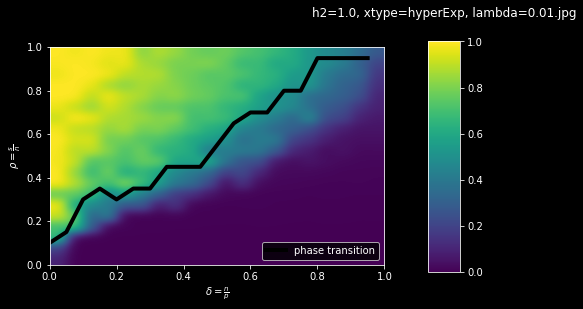

In [25]:
plot_transition(PTM, params, save = True)

### Multiple experiments:

We use cross validation to find best $\lambda$ to fit the data. 

In [51]:
from itertools import product

n = 1000
p = 1000
A = simul_data(n = n, p = p)

lambd = [2., 0.1, 0.01]
h2 = [0.5, 1.]
experiment = product(h2, lambd)

100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


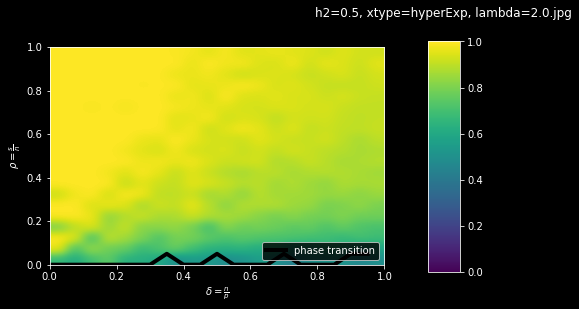

100%|██████████| 20/20 [01:45<00:00,  5.29s/it]


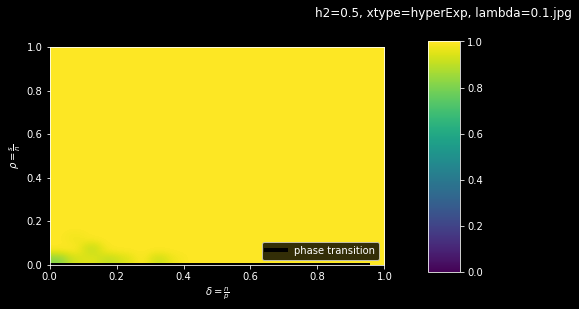

100%|██████████| 20/20 [03:26<00:00, 10.31s/it]


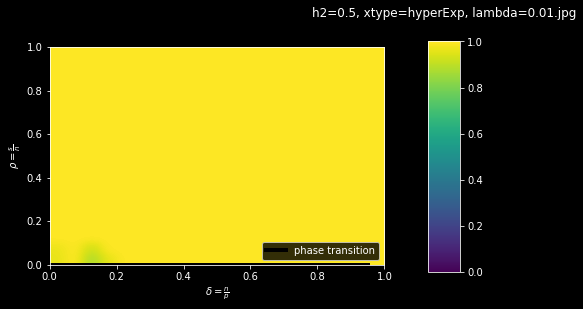

100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


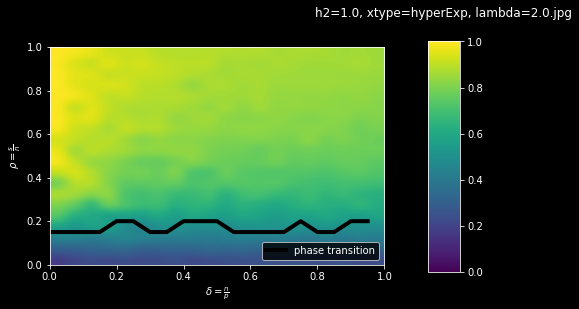

100%|██████████| 20/20 [00:46<00:00,  2.34s/it]


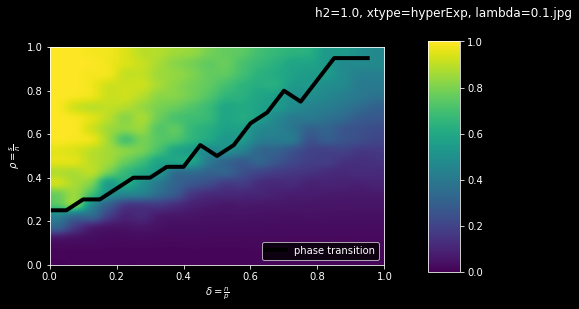

100%|██████████| 20/20 [02:06<00:00,  6.30s/it]


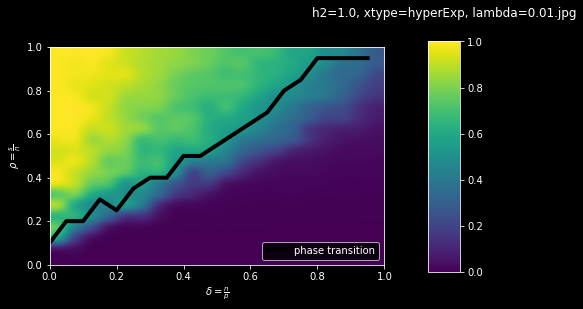

In [52]:
for i,e in enumerate(experiment):
    h2 = e[0]
    lambd = e[1]
    PTM, params = phase_transition_mat(A, lambd = lambd, h2 = h2, xtype = 'hyperExp', size=20, recovery= False)
    plot_transition(PTM, params, save = True, show = True)

100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


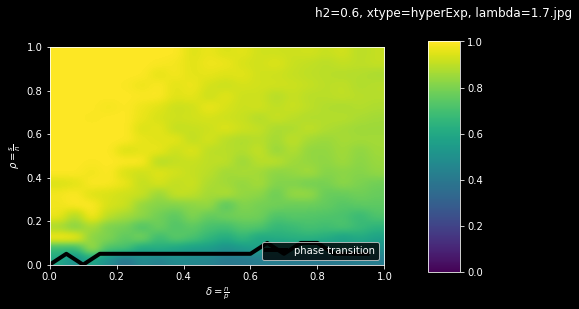

In [48]:
h2 = 0.6
lambd =1.7
PTM, params = phase_transition_mat(A, lambd = lambd, h2 = h2, xtype = 'hyperExp', size=20, recovery= False)
plot_transition(PTM, params, save = True, show = True)

100%|██████████| 20/20 [02:14<00:00,  6.73s/it]


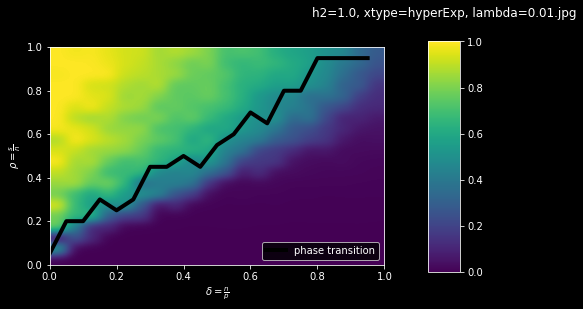

In [49]:
h2 = 1.
lambd = 0.01
PTM, params = phase_transition_mat(A, lambd = lambd, h2 = h2, xtype = 'hyperExp', size=20, recovery= False)
plot_transition(PTM, params, save = True, show = True)

### Test for one simulated matrix in a given point of the $\delta-\rho$ plane

In [13]:
p = 1000
A = simul_data(n = p, p = p)

In [14]:
rho = 0.3
delta = 0.1

n_tmp = int(p*delta)
s = int(rho*n_tmp)
x, y, e = genPhenotype(A=A[:n_tmp][:], s=s, h2=1.) 


In [15]:
# x_pred = lasso(A[ix_tmp, :], y, lambd = lambd)
x_pred, lambd = iterativeLasso(A[:n_tmp][:], y, nb_lambd=100, normalize=True)
print(NE(x, x_pred))

0.0686513178943


## Study of the recovery measures

In [16]:
def recovery(A, s, h2 = 1., xtype = 'hyperExp', lambd = 0.1, steps = 20):
    n = A.shape[0]
    p = A.shape[1]
    nstep = n // steps
    
    PPVs = []
    FPRs = []
    muPvals = []
    NEs = []
    
    x, y, e = genPhenotype(A=A, s=s, h2=h2, xtype=xtype)
    ix = np.arange(n)
    for i, n_tmp in tqdm(enumerate(np.arange(nstep, n, nstep))):
        ix_tmp = np.random.choice(ix, n_tmp, replace=False)
        A_tmp = A[ix_tmp][:]
        y_tmp = y[ix_tmp]
        #x, y, e = genPhenotype(A=A_tmp, s=s, h2=h2)
        
        # Choose if you want to prefer either a cross validation to select lambdas
        # or a standart lasso with a given lambda (faster)
        x_pred = lasso(A_tmp, y_tmp, lambd = lambd)
        # x_pred, la = iterativeLasso(A_tmp, y, nb_lambd=100, normalize=True, verbose=False)
        PPVs.append(PPV(x, x_pred))
        FPRs.append(FPR(x, x_pred))
        muPvals.append(med_P(A=A_tmp, y=y_tmp, x_hat=x_pred))
        NEs.append(NE(x=x, x_hat=x_pred))
        
    return np.array(PPVs), np.array(FPRs), np.array(muPvals), np.array(NEs), np.arange(nstep, n, nstep)

In [39]:
def recovery_plot(PPvs, FPRs, muPvals, NEs, ns, params, save = True, show = True):
    plt.figure(figsize = (20,5))

    plt.subplot(121)
    plt.scatter(ns, NEs, label = 'NE')
    plt.legend()

    plt.subplot(122)
    plt.scatter(ns, PPVs, label='PPsV', c='#C11500')
    plt.scatter(ns, FPRs, label='FPR', c='#5AFF1A')
    plt.scatter(ns, muPvals, label='medP', c='#1116B2')
    plt.legend()
    plt.title('p={}, s={}, lambd={}, h2={}'.format(*params[:-1]))
    if save:
        filename = 'imgs/transition_curve_p={}_sparse={}_lambda={}_(h2={}_xtype={}).jpg'.format(*params)
        plt.savefig(filename, bbox_inches='tight')
    if show:
        plt.show()
    return 

19it [00:40,  2.11s/it]


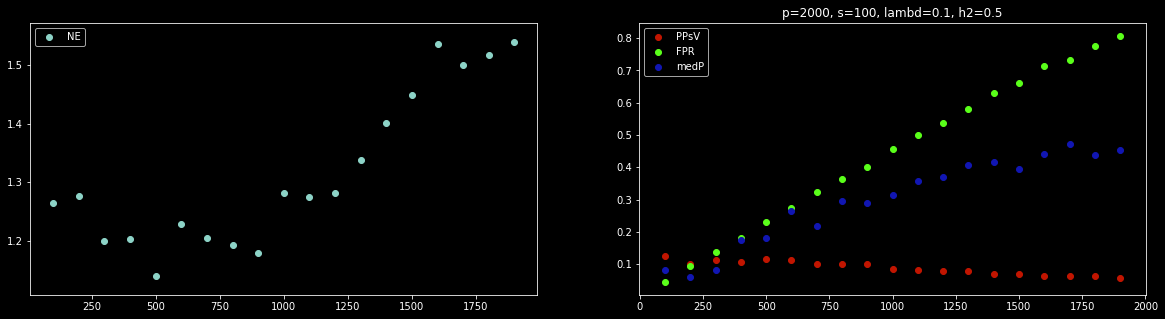

In [47]:
n = 2000
s = 100
h2 = 0.5
xtype = 'hyperExp'
lambd = 0.1
params = [n, s, lambd, h2, xtype]

A = simul_data(n=n, p=n)
PPVs, FPRs, muPvals, NEs, ns = recovery(A= A, s = s, h2= h2, xtype = xtype, lambd = lambd, steps=20)
recovery_plot(PPVs, FPRs, muPvals, NEs, ns, params, show = True, save = True)

19it [00:07,  2.45it/s]


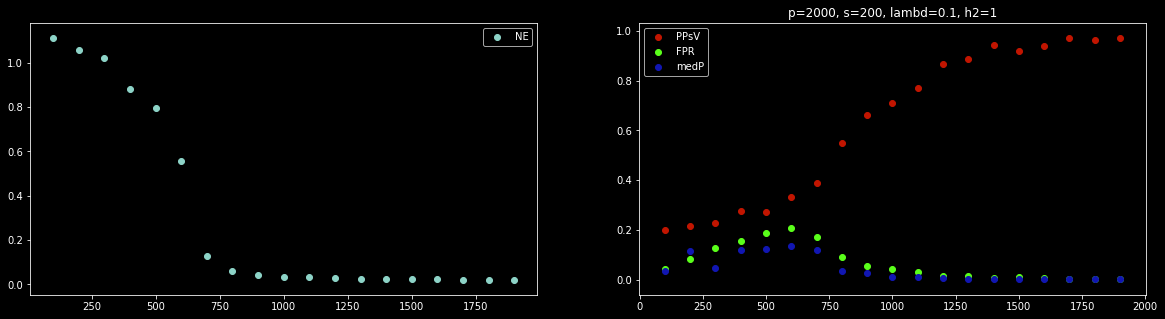

19it [00:21,  1.12s/it]


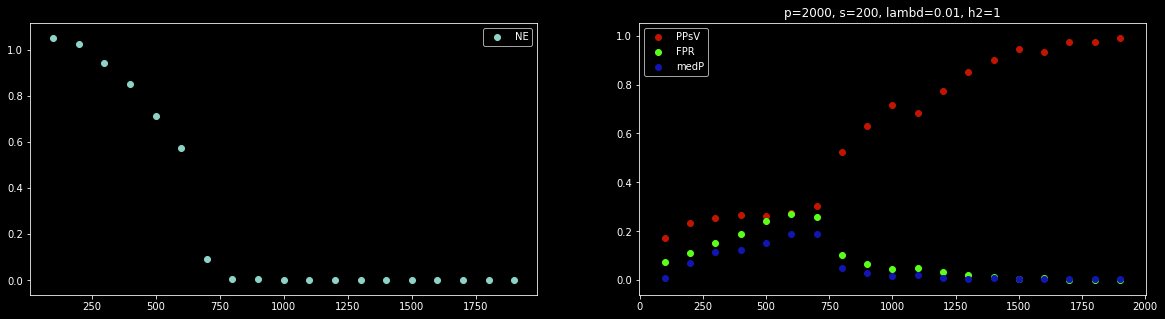

19it [01:14,  3.94s/it]


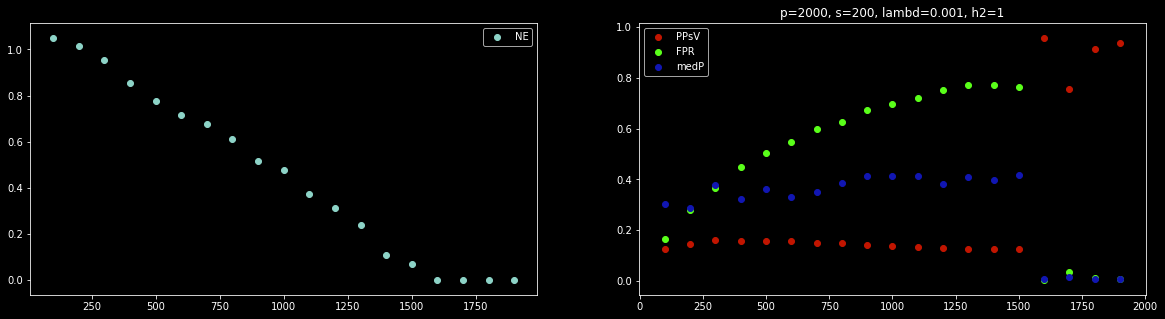

In [48]:
n = 2000
s = 200
h2 = 1
xtype = 'hyperExp'
lambd = 0.1
for lambd in [0.1, 0.01, 0.001]:
    params = [n, s, lambd, h2, xtype]
    A = simul_data(n=n, p=n)
    PPVs, FPRs, muPvals, NEs, ns = recovery(A= A, s = s, h2= h2, xtype = xtype, lambd = lambd, steps=20)
    recovery_plot(PPVs, FPRs, muPvals, NEs, ns, params, show = True, save = True)